In [1]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import unsupervised_scripts
import helper_scripts
from tkinter import Tk, filedialog


## Sample Directory (different for everyone)
data_dir = os.getcwd()


## Load Image
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

data_dir = sample[0][:indeces[-2]+1]

save_dir = data_dir+sample_name+'/'
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = 2700 #int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = 3100 #int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift=0)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=20)
X_norm = helper_scripts.normalize(X_norm, max=np.max(image_norm))
X_norm = (X_norm.T-np.median(X_norm[:ch_start])).T
# save_input = helper_scripts.save_input()
save_input = True


2025-04-17 21:34:05.108 python[10108:695359] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-17 21:34:05.325 python[10108:695359] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


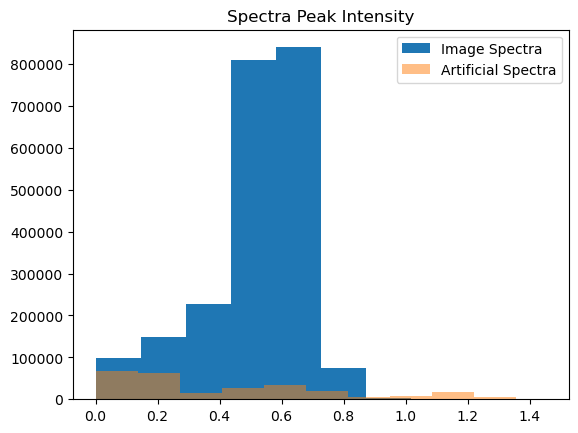

In [2]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0], label = "Image Spectra")
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5, label = "Artificial Spectra")
plt.legend()
plt.title("Spectra Peak Intensity")
plt.show()

In [3]:
def macro_idx(wavenumber, num_samp, wavenum_1=2700, wavenum_2=3100):
    idx = int(((wavenumber - wavenum_1) / (wavenum_2 - wavenum_1)) * num_samp)
    return idx

In [4]:
## Save Normalized Image and channels (ONLY FOR 2700-3100)
unsat_idx = macro_idx(3010+20, num_samp, wavenum_1, wavenum_2)
protein_idx = macro_idx(2938+20, num_samp, wavenum_1, wavenum_2)
sat_idx = macro_idx(2885+20, num_samp, wavenum_1, wavenum_2)
lipid_idx = macro_idx(2850+20, num_samp, wavenum_1, wavenum_2)



norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
norm_image = np.moveaxis(norm_image, 2, 0)
io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[list(range(unsat_idx-1, unsat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[list(range(protein_idx-1, protein_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[list(range(sat_idx-1, sat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[list(range(lipid_idx-1, lipid_idx+1))],axis=0).astype('float32'))

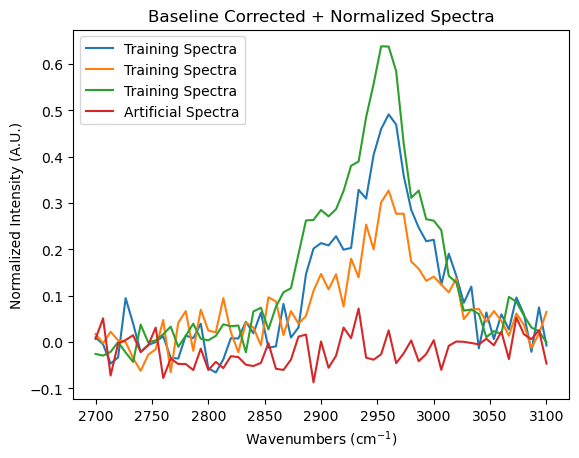

In [5]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')
plt.show()

In [6]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

Accuracy Score: 0.9451538461538461


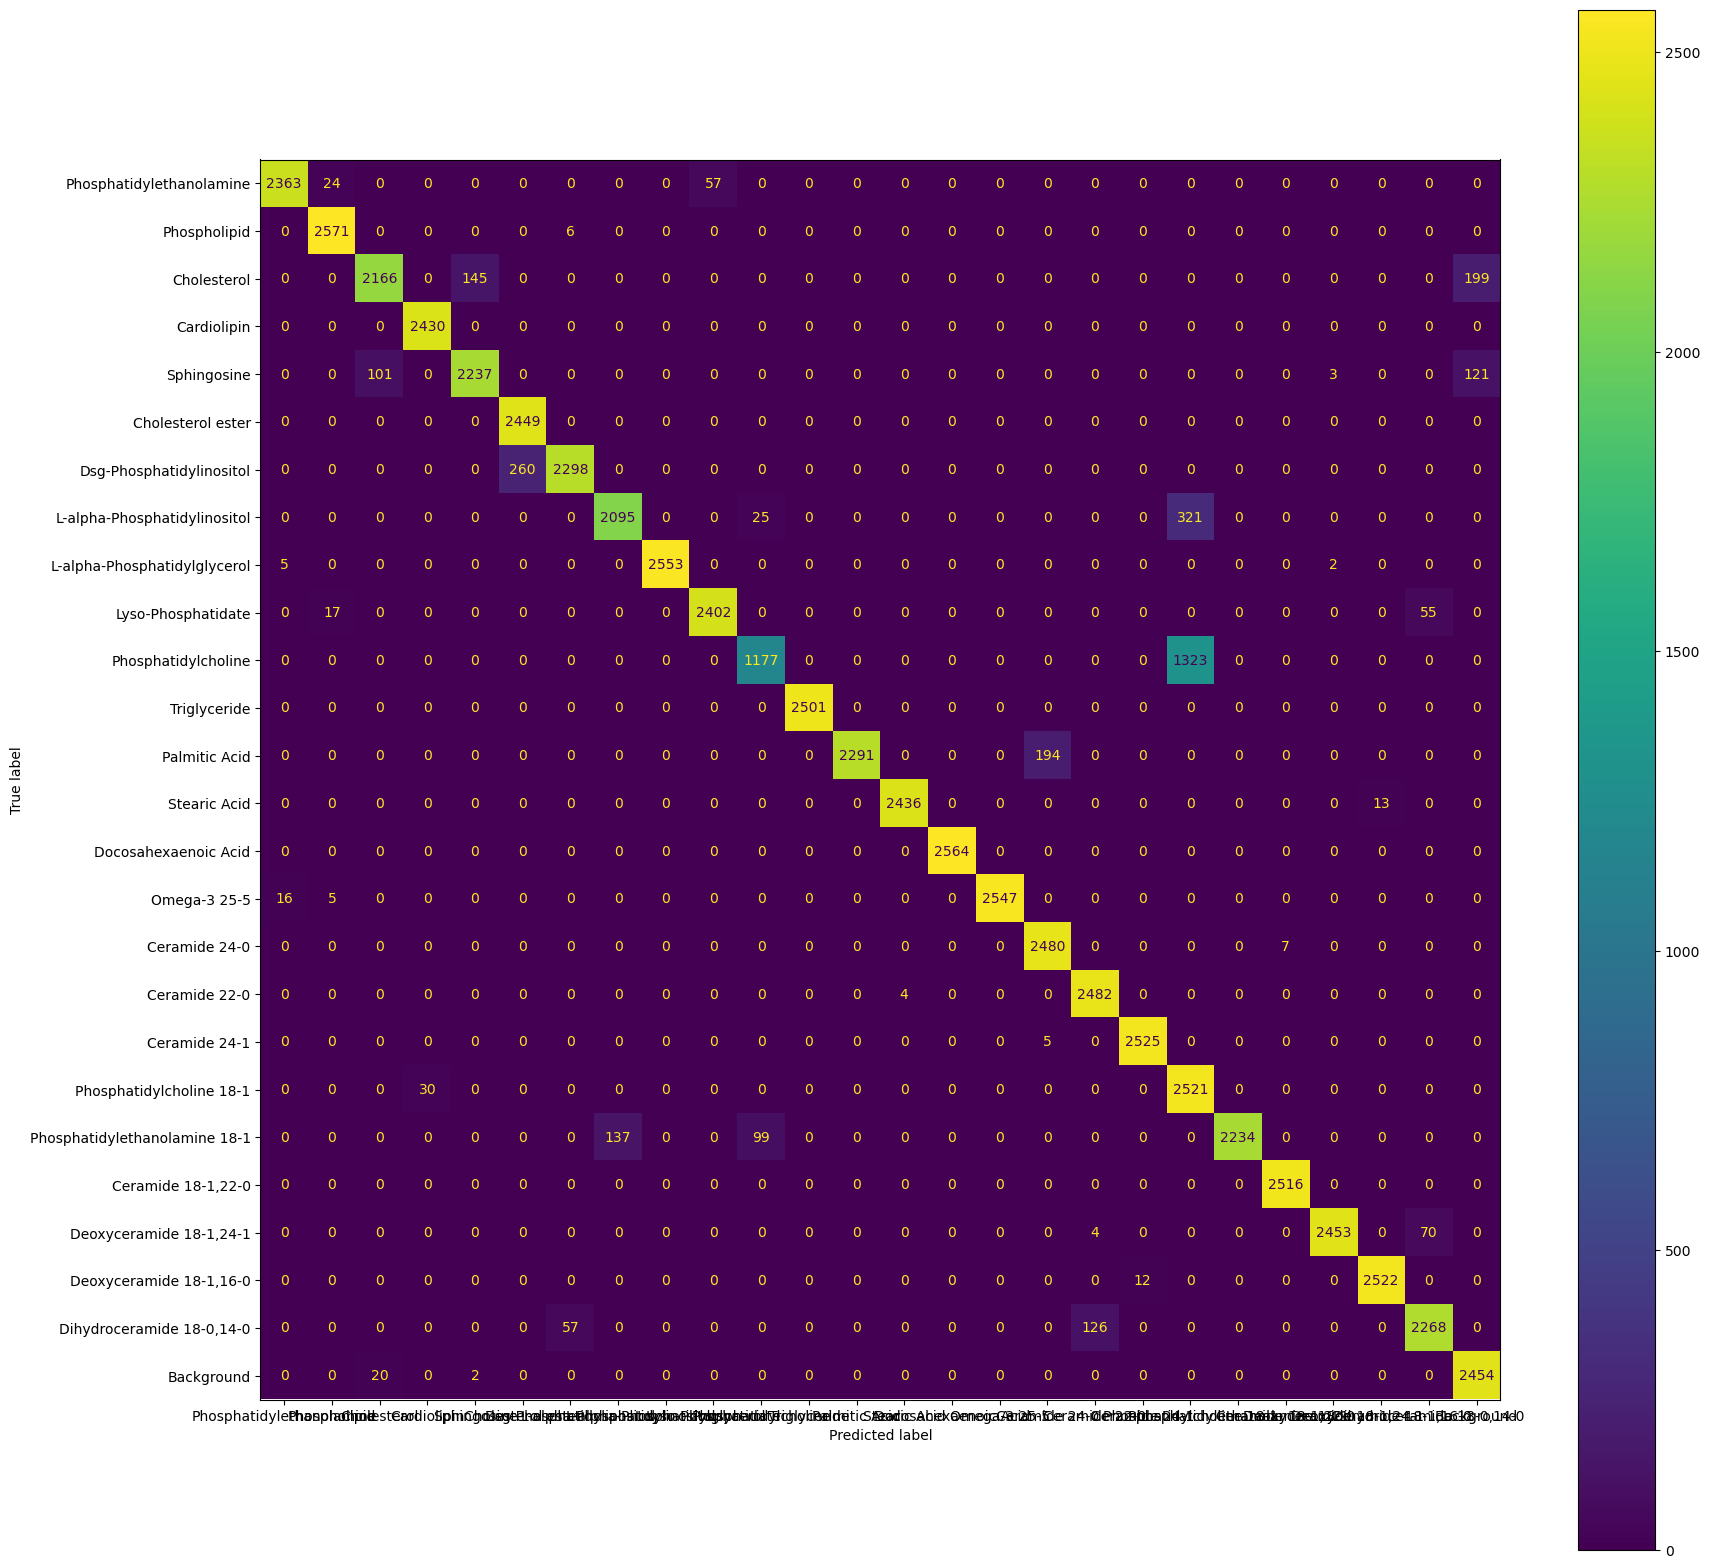

In [7]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x[~np.all(x==0, axis=1)], X, Y, .25)
num_estimators = 500
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'_'+str(num_estimators)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)
plt.show()


In [8]:
## Use Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x[~np.all(x==0, axis=1)], mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 106.50156879425049 seconds


 84%|████████▍ | 21/25 [00:01<00:00, 13.09it/s]/Users/jorgevillazon/Documents/GitHub/hsi_machine_learning/ML/unsupervised_scripts.py:450: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))
 44%|████▍     | 11/25 [00:00<00:00, 29.68it/s]/Users/jorgevillazon/miniconda3/envs/ML/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/ADATA SE880/02-10-25 CosMX 20240703c/Bottom-zoom4/Cortex/fused-fixed-1.2-HSI.tif/Palmitic Acid-Probability_Figure.tif is a low contrast image
  return func(*args, **kwargs)
 60%|██████    | 15/25 [00:00<00:00, 29.71it/s]/Users/jorgevillazon/miniconda3/envs/ML/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/ADAT

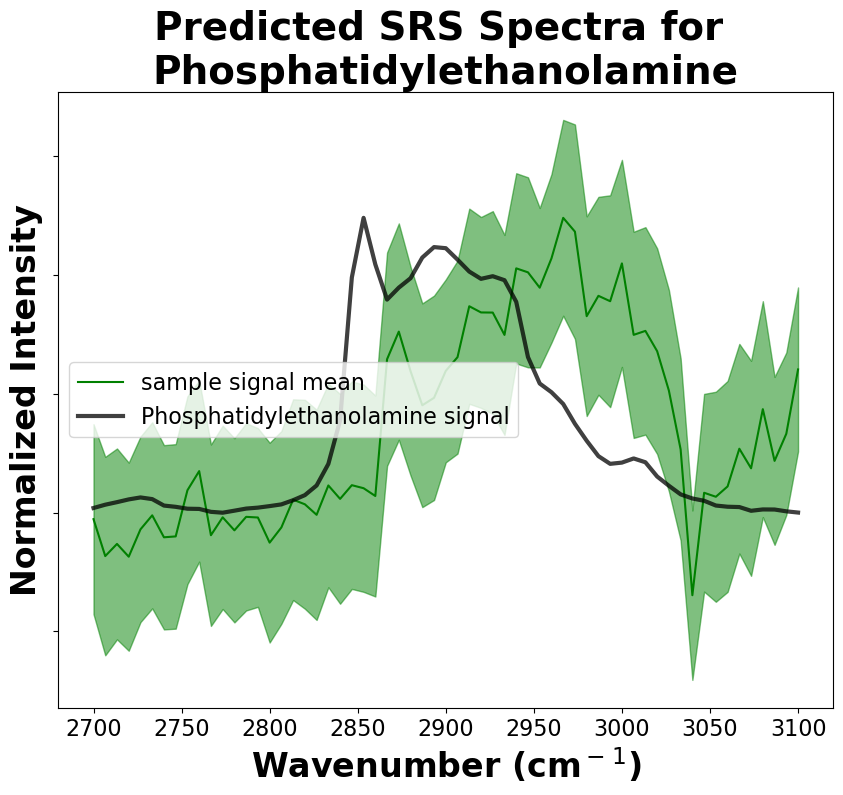

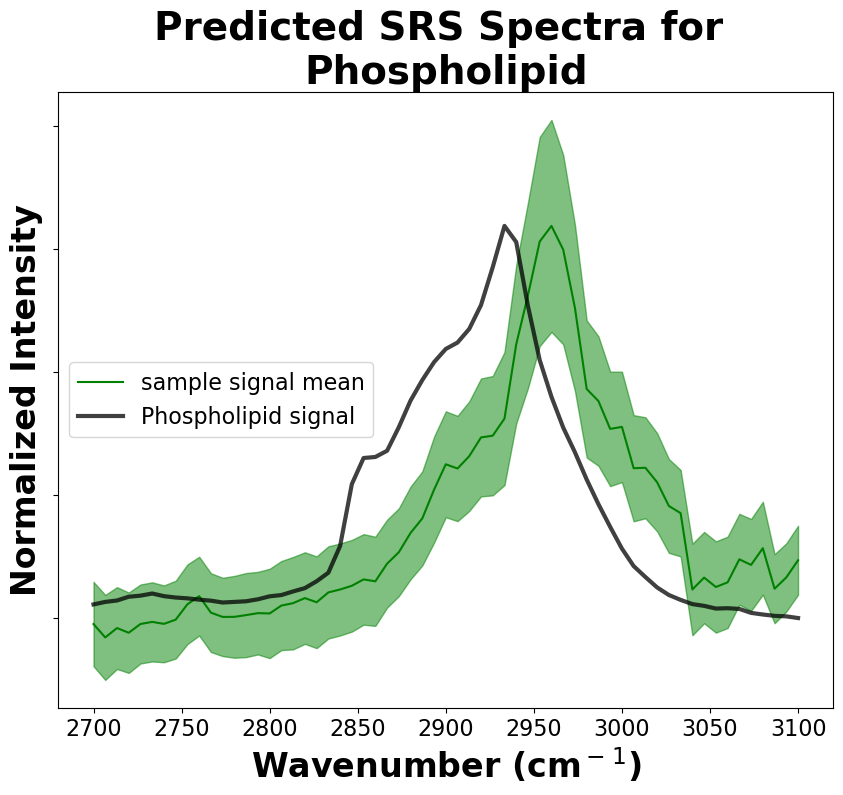

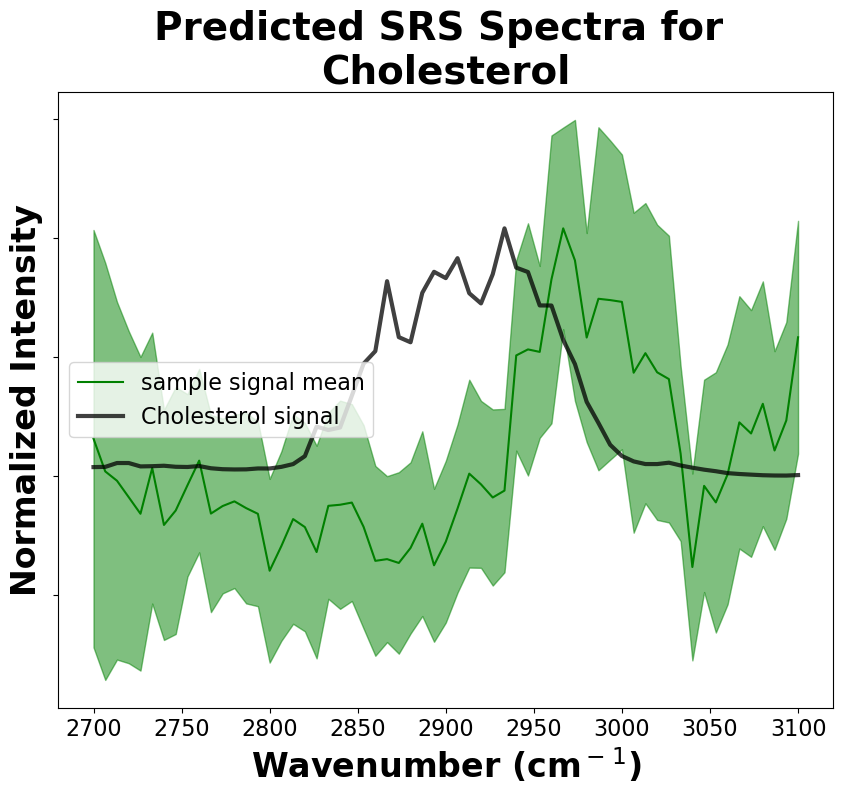

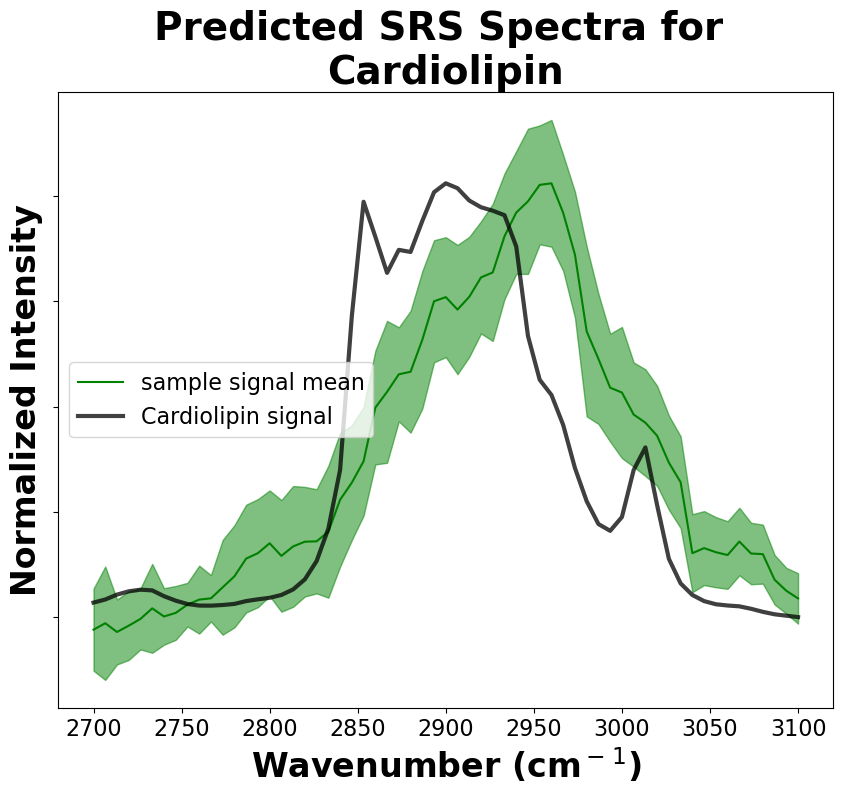

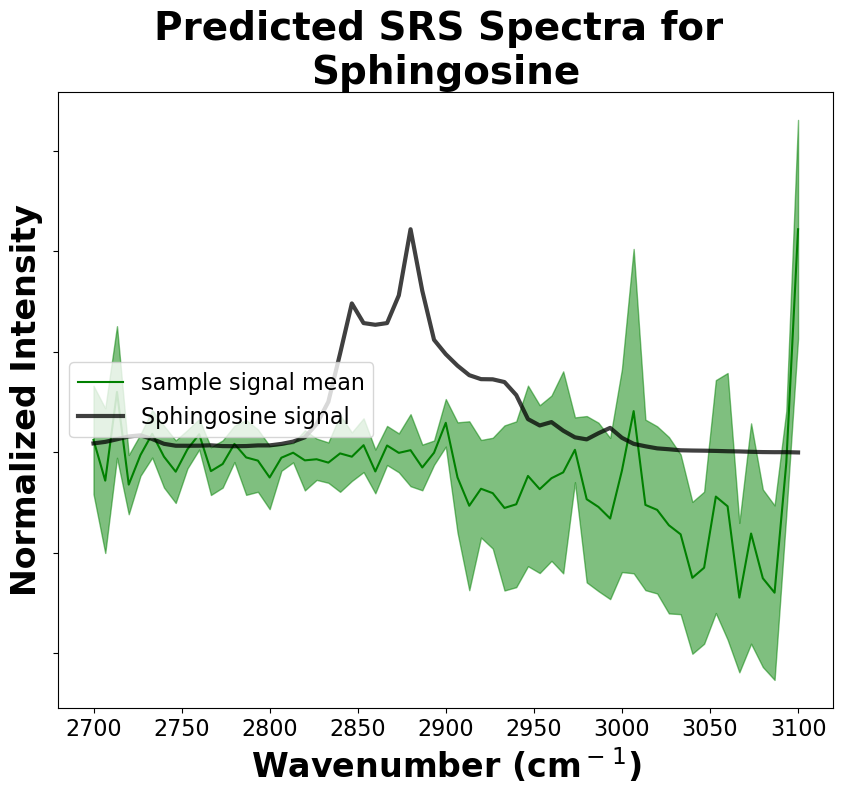

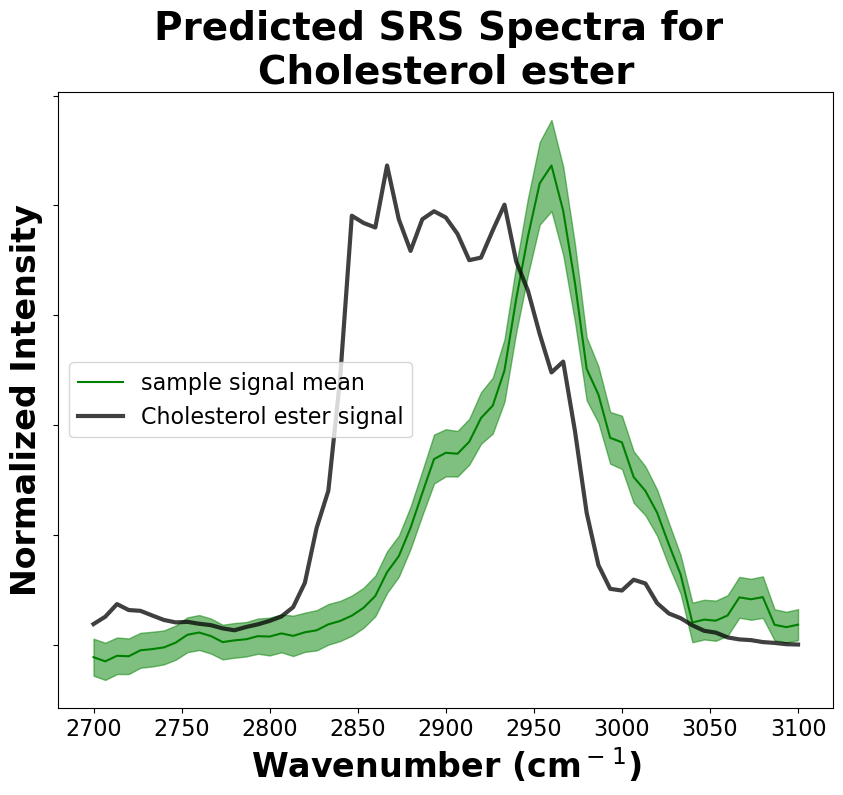

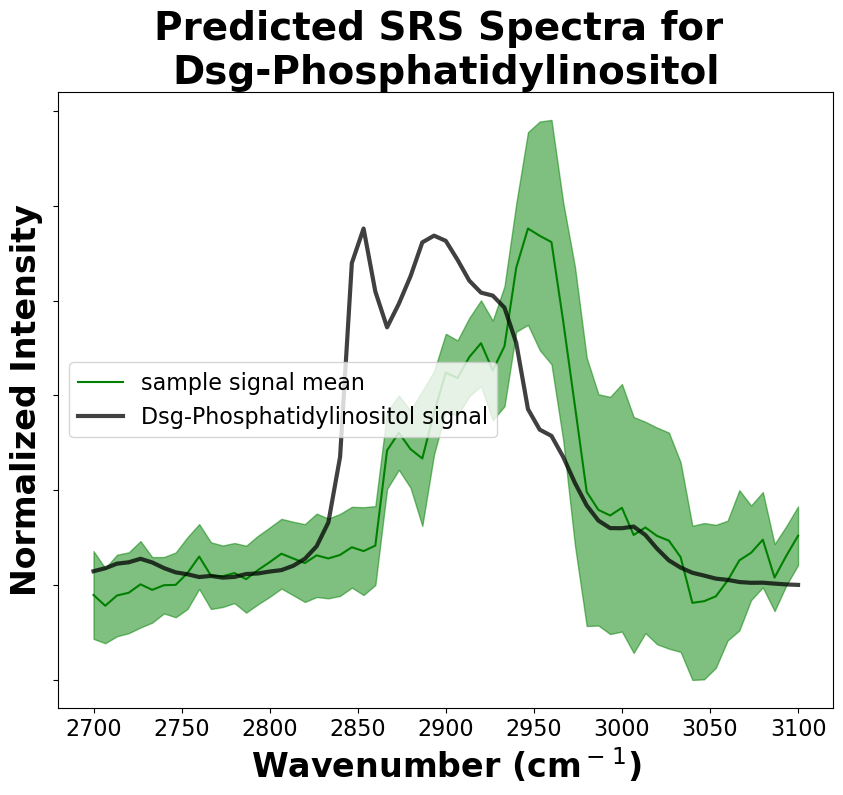

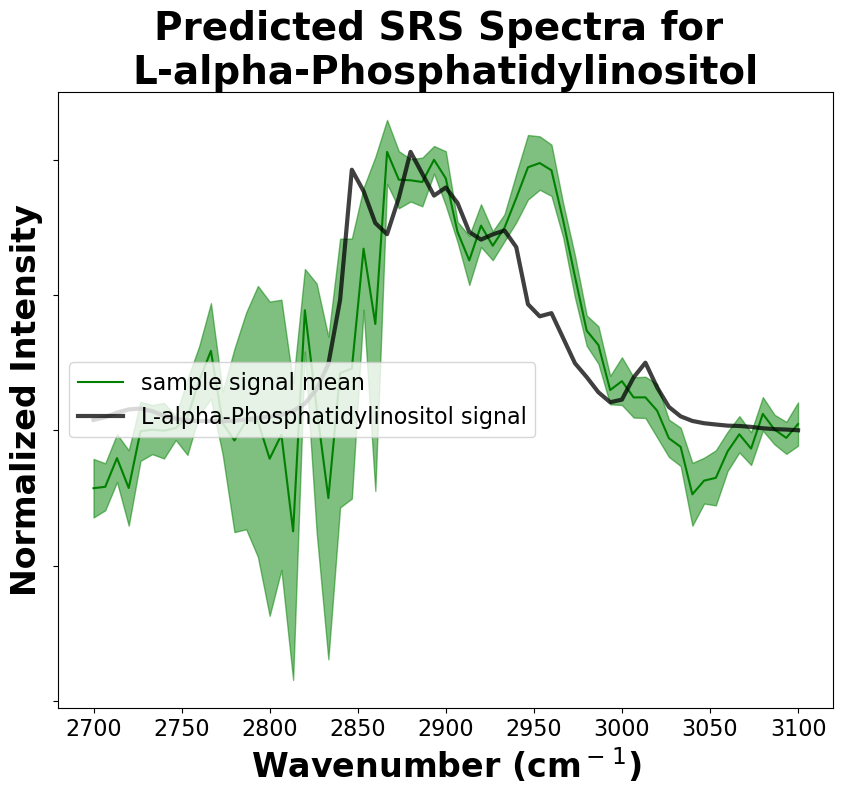

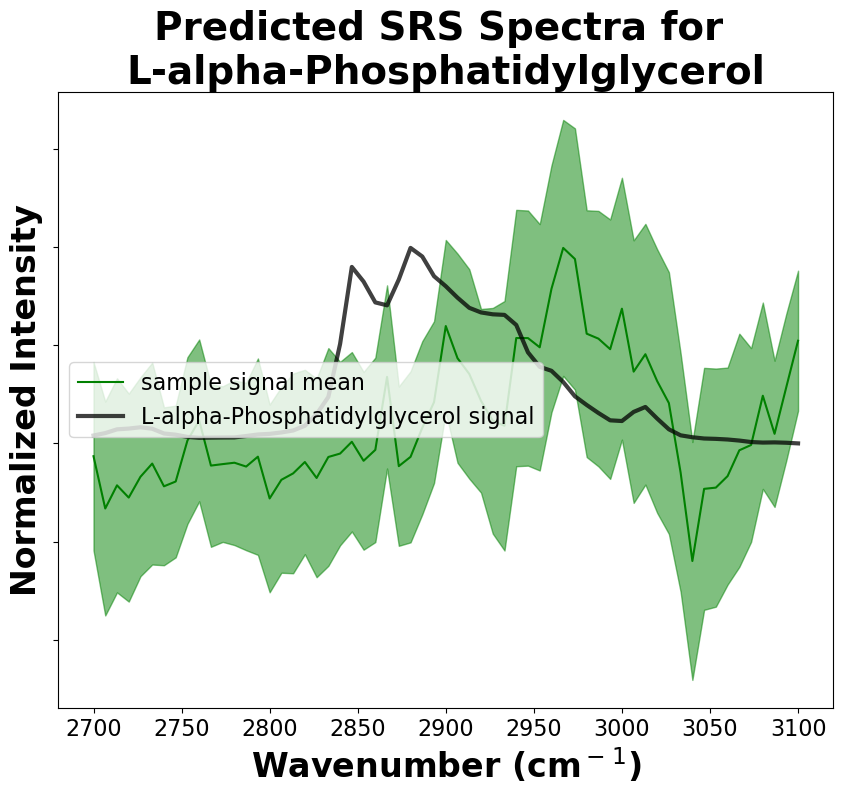

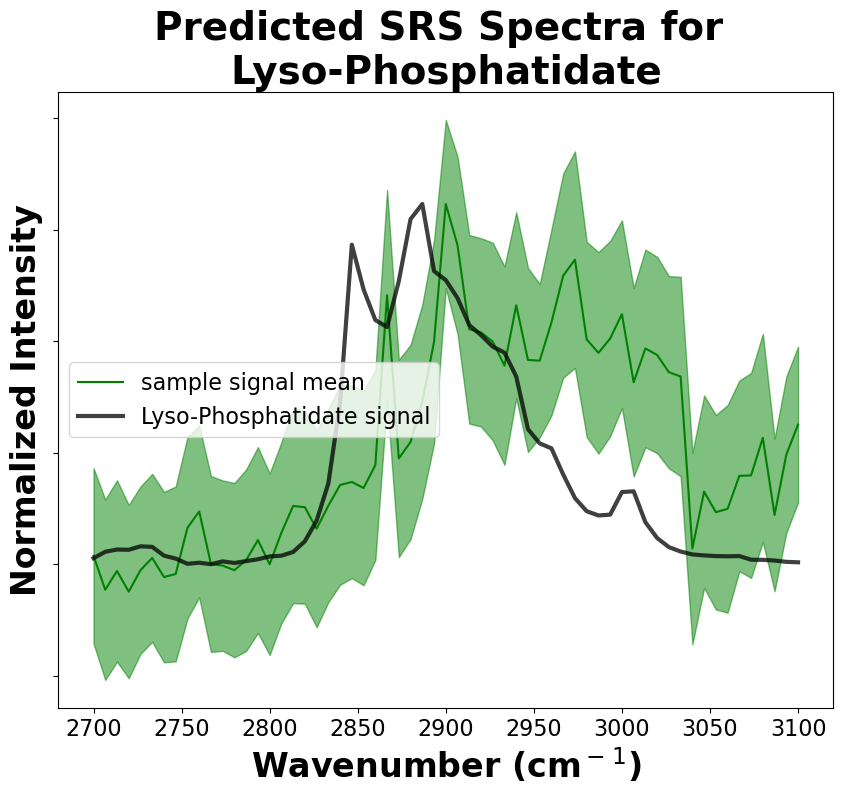

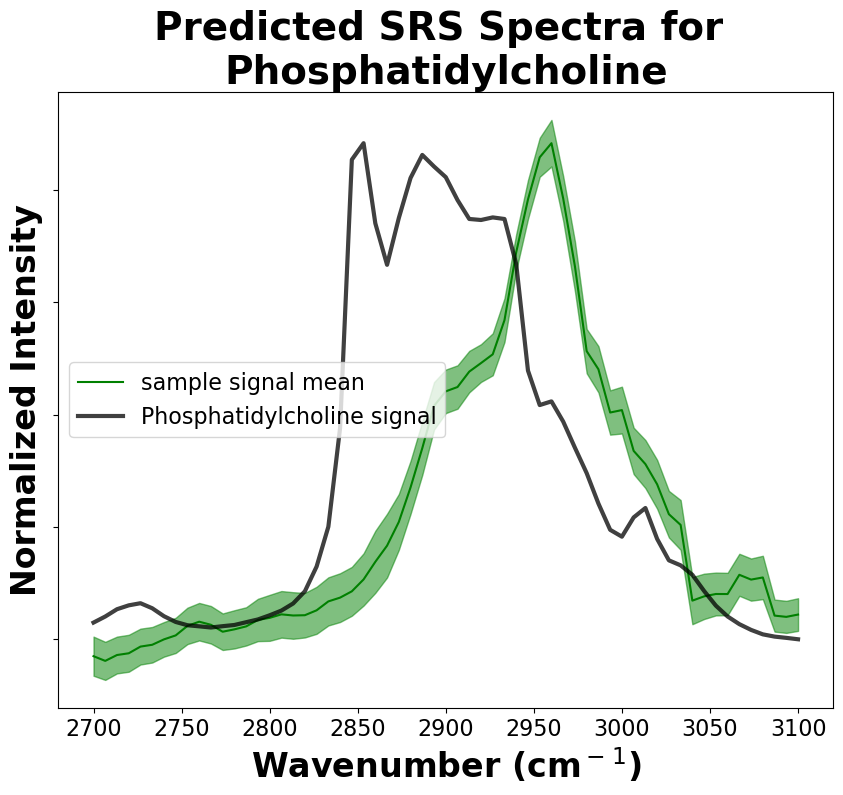

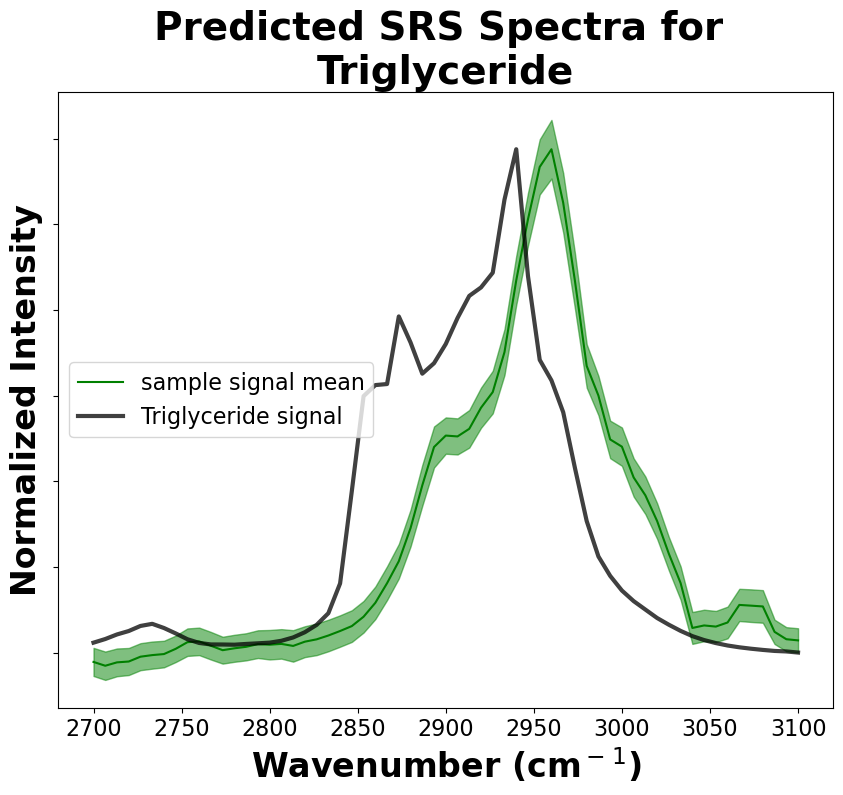

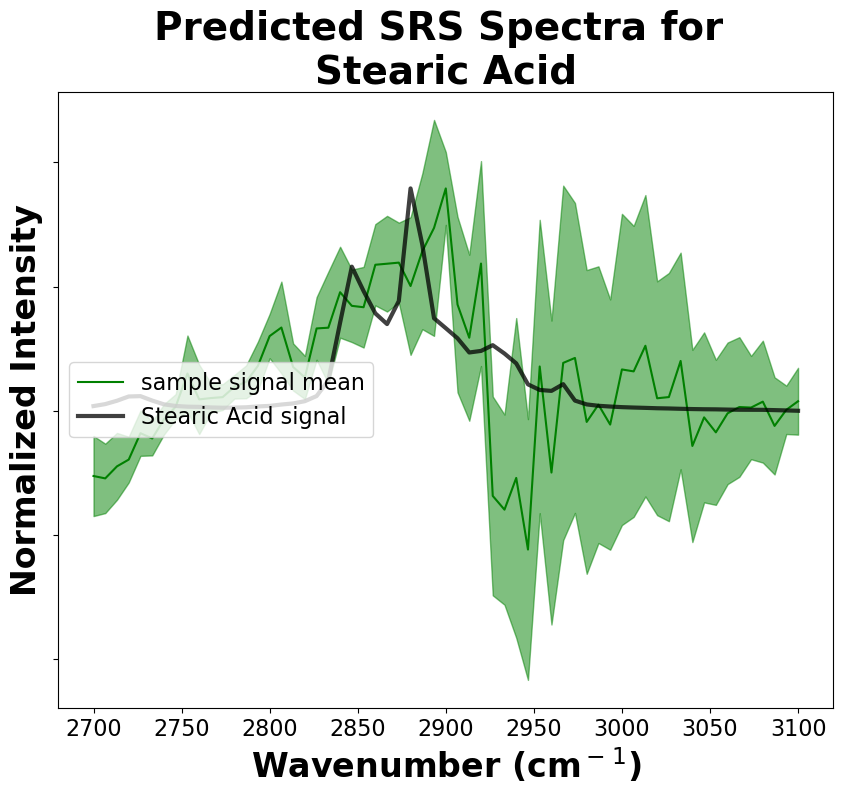

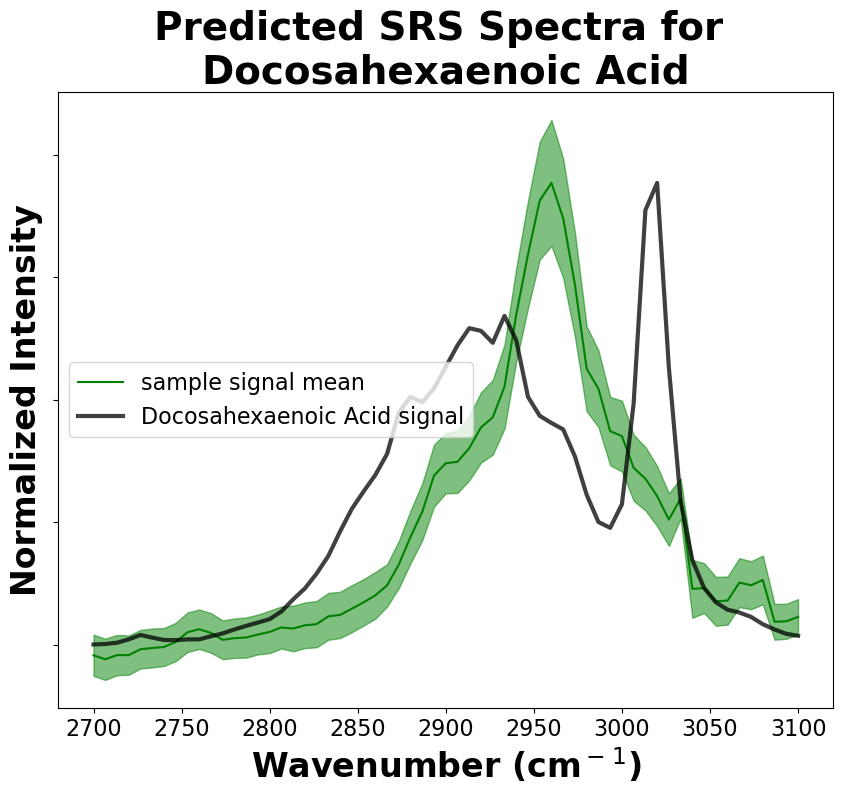

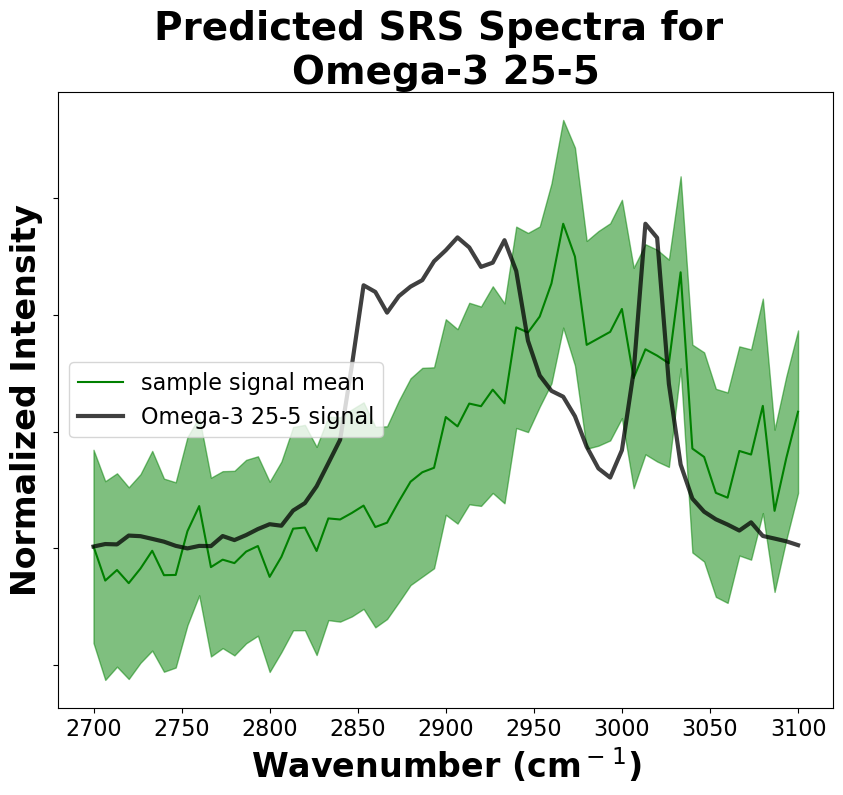

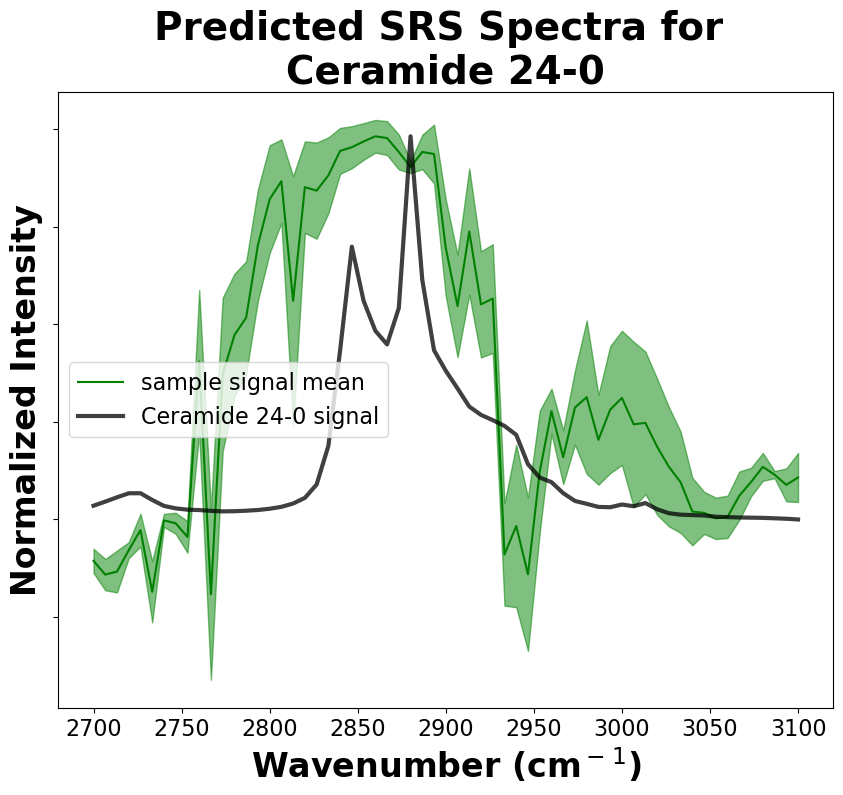

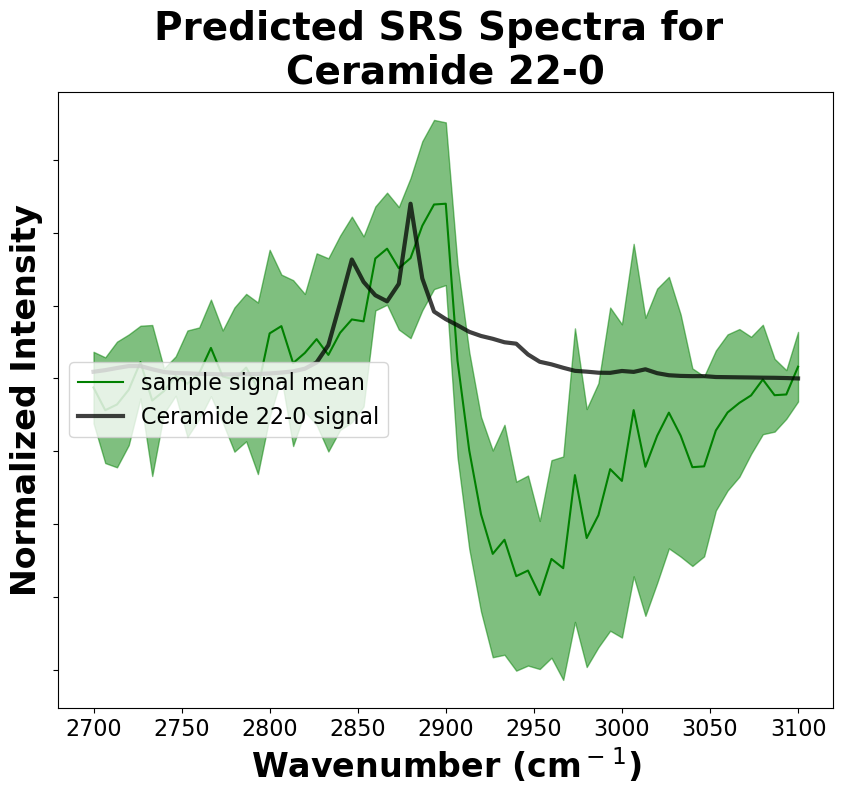

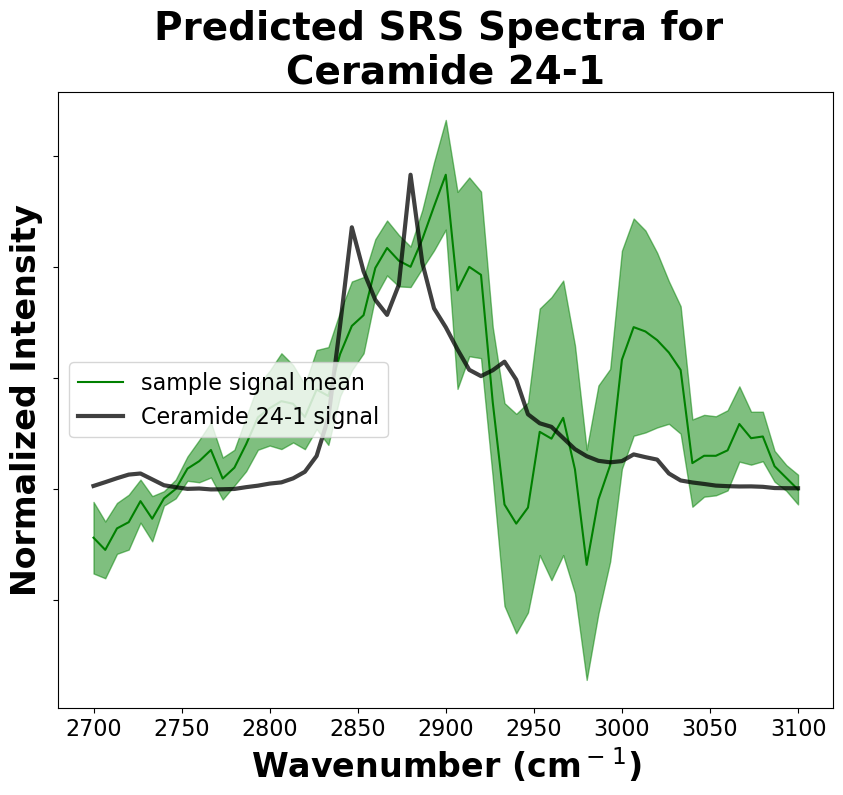

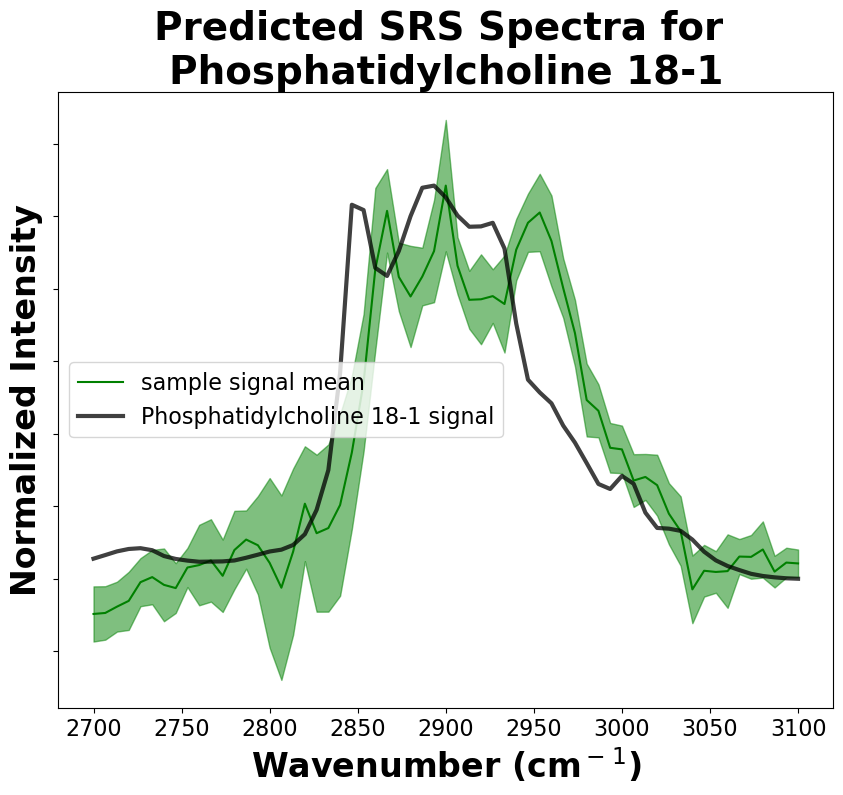

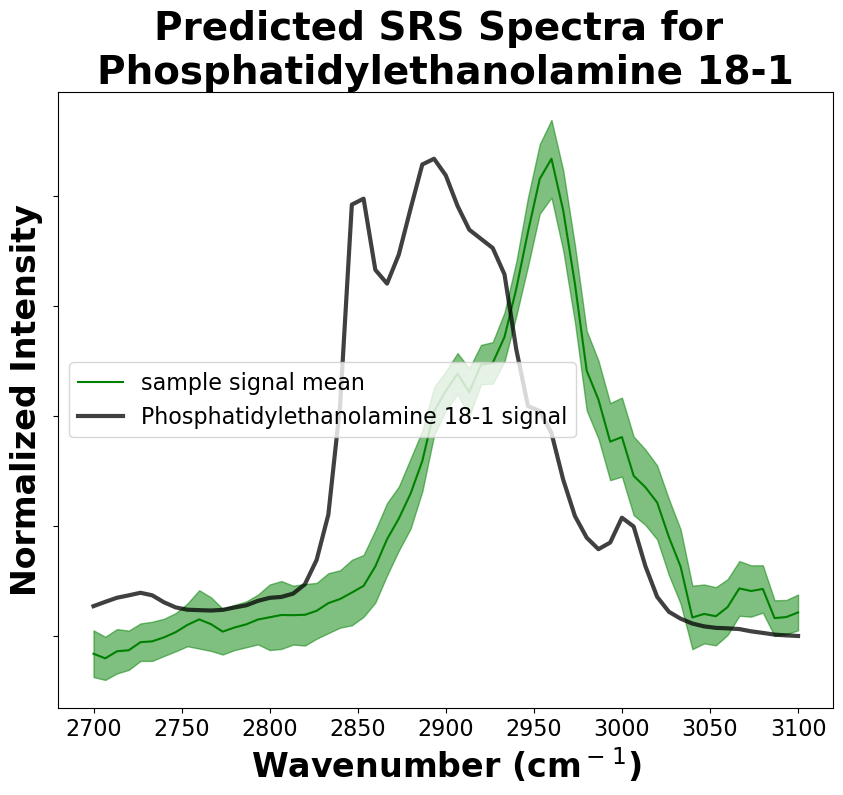

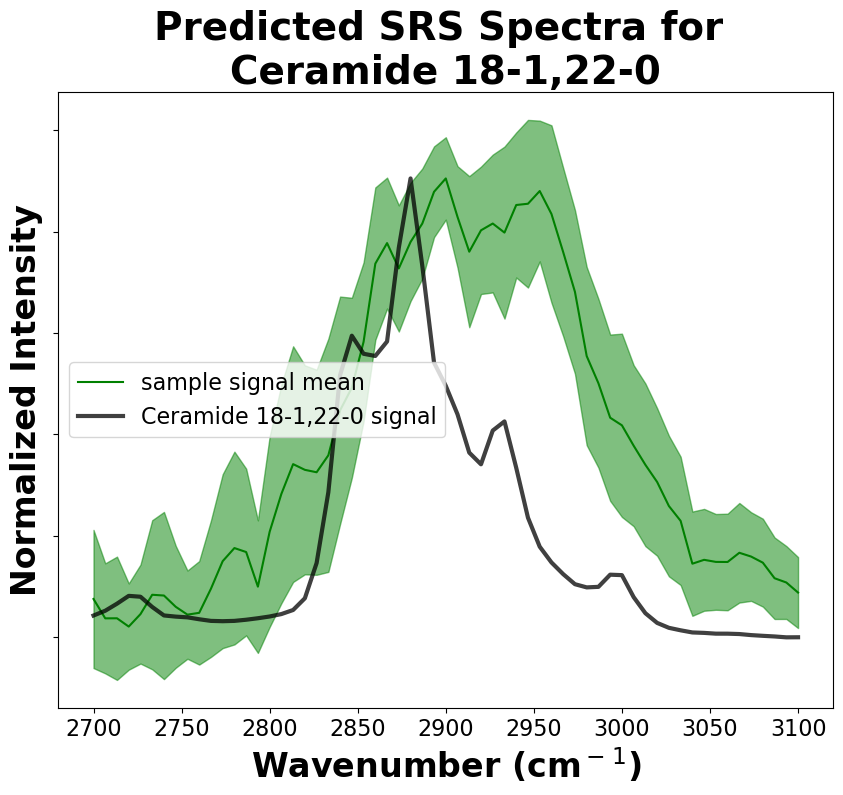

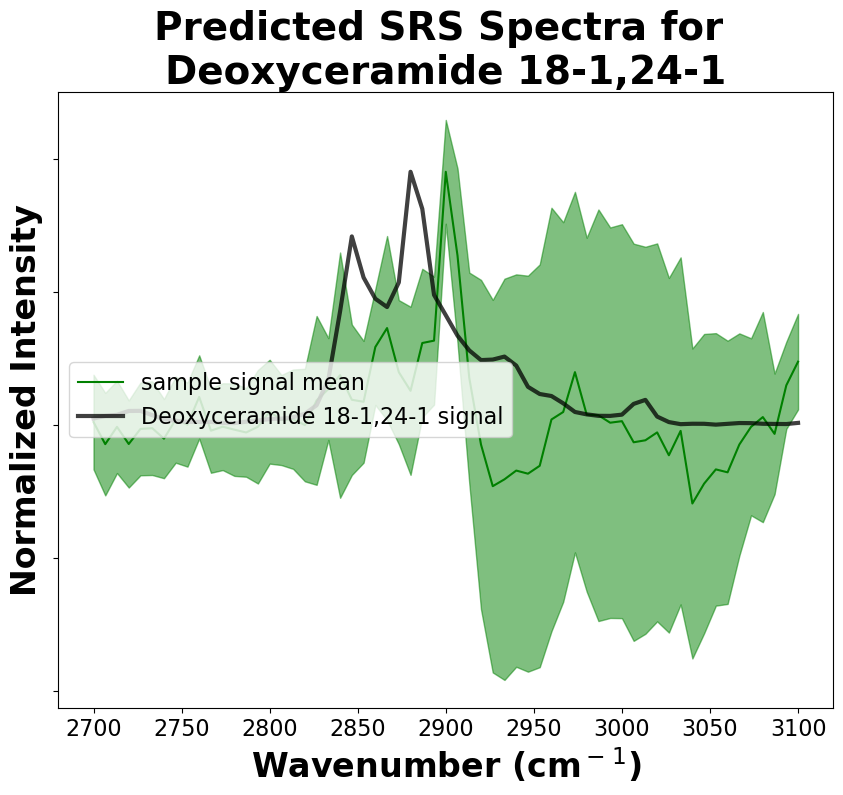

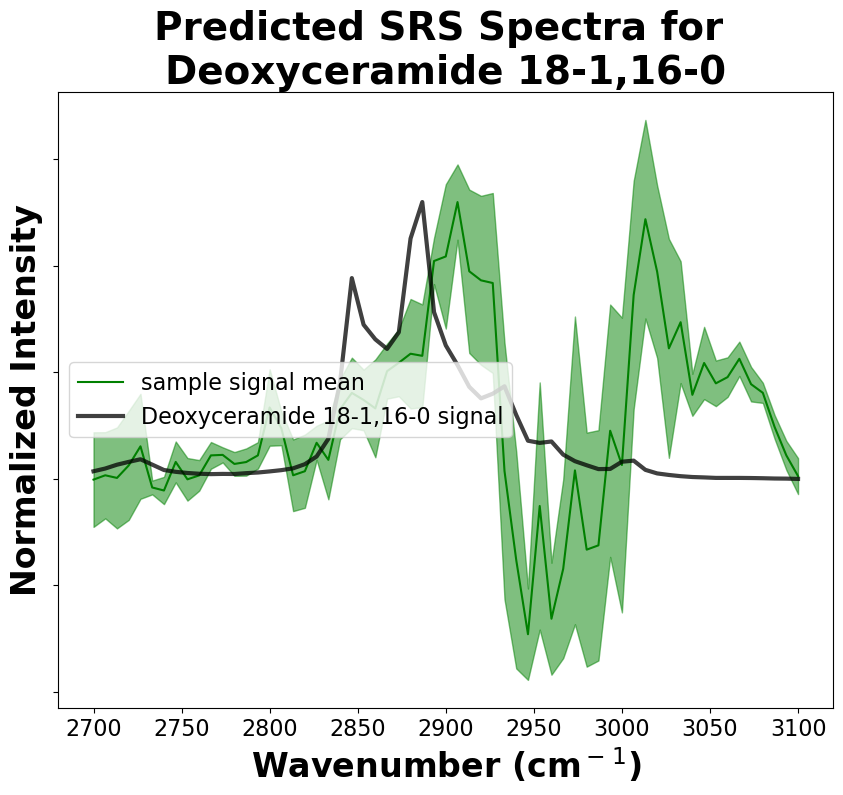

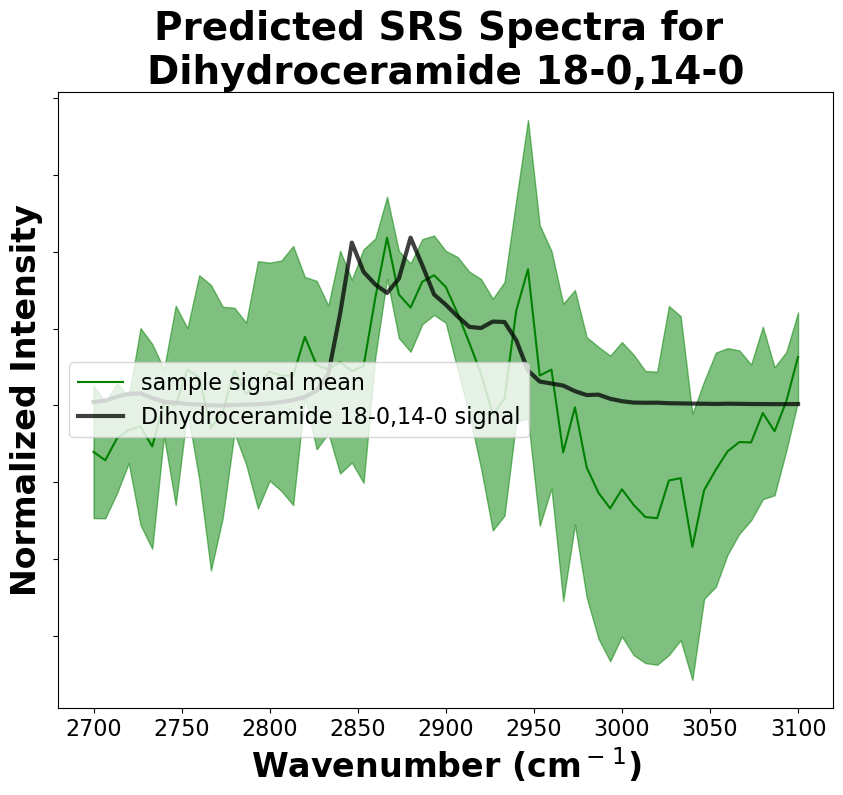

In [9]:
## Spectral Graphs
# save_input = helper_scripts.save_input()
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [10]:
import helper_scripts
print('Save similarity metric .csv?')
# save_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 2425/2425 [00:00<00:00, 4495.10it/s]


The MSE for Phosphatidylethanolamine is: 0.0012543489869921386
The Cosine Similarity for Phosphatidylethanolamine is: 0.4061836535847731
The Cross-Correlation for Phosphatidylethanolamine is: 0.5566856519339863


100%|██████████| 224059/224059 [00:50<00:00, 4423.91it/s]


The MSE for Phospholipid is: 0.03433072312281269
The Cosine Similarity for Phospholipid is: 0.29555418410168116
The Cross-Correlation for Phospholipid is: 0.46342817987858953


100%|██████████| 385/385 [00:00<00:00, 4342.37it/s]


The MSE for Cholesterol is: 0.0018902998054456863
The Cosine Similarity for Cholesterol is: 0.12326109504304232
The Cross-Correlation for Cholesterol is: 0.14840867703427701


100%|██████████| 301/301 [00:00<00:00, 4348.64it/s]


The MSE for Cardiolipin is: 0.047354696487923266
The Cosine Similarity for Cardiolipin is: 0.8416817374930533
The Cross-Correlation for Cardiolipin is: 0.9550516893701474


100%|██████████| 19/19 [00:00<00:00, 4237.12it/s]


The MSE for Sphingosine is: 0.00214040322620146
The Cosine Similarity for Sphingosine is: -0.02023770281684782
The Cross-Correlation for Sphingosine is: 0.12557584421048182


100%|██████████| 523747/523747 [01:51<00:00, 4696.13it/s]


The MSE for Cholesterol ester is: 0.024765848843992553
The Cosine Similarity for Cholesterol ester is: 0.6787261639242597
The Cross-Correlation for Cholesterol ester is: 0.8993772441315212


100%|██████████| 240/240 [00:00<00:00, 4474.10it/s]


The MSE for Dsg-Phosphatidylinositol is: 0.005619484689952021
The Cosine Similarity for Dsg-Phosphatidylinositol is: 0.6638511528827802
The Cross-Correlation for Dsg-Phosphatidylinositol is: 0.9081856882698669


100%|██████████| 10/10 [00:00<00:00, 3887.93it/s]


The MSE for L-alpha-Phosphatidylinositol is: 0.05231466386168008
The Cosine Similarity for L-alpha-Phosphatidylinositol is: 0.5877452303014319
The Cross-Correlation for L-alpha-Phosphatidylinositol is: 0.5877452303014322


100%|██████████| 1144/1144 [00:00<00:00, 4456.57it/s]


The MSE for L-alpha-Phosphatidylglycerol is: 0.04245011274034004
The Cosine Similarity for L-alpha-Phosphatidylglycerol is: 0.020036137050927917
The Cross-Correlation for L-alpha-Phosphatidylglycerol is: 0.5135134006023415


100%|██████████| 1351/1351 [00:00<00:00, 4387.75it/s]


The MSE for Lyso-Phosphatidate is: 0.0241368972848547
The Cosine Similarity for Lyso-Phosphatidate is: -0.03274618818420959
The Cross-Correlation for Lyso-Phosphatidate is: 0.17623251321669703


100%|██████████| 13440/13440 [00:03<00:00, 4451.15it/s]


The MSE for Phosphatidylcholine is: 0.020913285828092293
The Cosine Similarity for Phosphatidylcholine is: 0.7286969015570305
The Cross-Correlation for Phosphatidylcholine is: 0.9263908912612496


100%|██████████| 1335664/1335664 [04:48<00:00, 4627.04it/s]


The MSE for Triglyceride is: 0.0171206418227367
The Cosine Similarity for Triglyceride is: 0.8460116255468615
The Cross-Correlation for Triglyceride is: 0.9696924689759099


100%|██████████| 16/16 [00:00<00:00, 3858.38it/s]


The MSE for Stearic Acid is: 0.14917091754949516
The Cosine Similarity for Stearic Acid is: 0.18696545928660202
The Cross-Correlation for Stearic Acid is: 0.41051850152893515


100%|██████████| 77217/77217 [00:17<00:00, 4427.89it/s]


The MSE for Docosahexaenoic Acid is: 0.040509121259012584
The Cosine Similarity for Docosahexaenoic Acid is: 0.4932348470834891
The Cross-Correlation for Docosahexaenoic Acid is: 0.6738504734707945


100%|██████████| 18117/18117 [00:04<00:00, 4369.25it/s]


The MSE for Omega-3 25-5 is: 0.0010277953974690114
The Cosine Similarity for Omega-3 25-5 is: 0.5180850304829236
The Cross-Correlation for Omega-3 25-5 is: 0.6447573527193354


100%|██████████| 3/3 [00:00<00:00, 3749.38it/s]


The MSE for Ceramide 24-0 is: 0.1111255677450583
The Cosine Similarity for Ceramide 24-0 is: 0.7156317140594232
The Cross-Correlation for Ceramide 24-0 is: 0.7175069799121713


100%|██████████| 40/40 [00:00<00:00, 4244.92it/s]


The MSE for Ceramide 22-0 is: 0.07193348967643028
The Cosine Similarity for Ceramide 22-0 is: 0.046540311398271625
The Cross-Correlation for Ceramide 22-0 is: 0.3545869802823079


100%|██████████| 16/16 [00:00<00:00, 4025.24it/s]


The MSE for Ceramide 24-1 is: 0.0694432738430497
The Cosine Similarity for Ceramide 24-1 is: 0.5577807146025328
The Cross-Correlation for Ceramide 24-1 is: 0.801573603366147


100%|██████████| 67/67 [00:00<00:00, 4231.44it/s]


The MSE for Phosphatidylcholine 18-1 is: 0.012214588507026333
The Cosine Similarity for Phosphatidylcholine 18-1 is: 0.9033249997809468
The Cross-Correlation for Phosphatidylcholine 18-1 is: 0.9480835994133837


100%|██████████| 3297/3297 [00:00<00:00, 4383.05it/s]


The MSE for Phosphatidylethanolamine 18-1 is: 0.023308506221665217
The Cosine Similarity for Phosphatidylethanolamine 18-1 is: 0.6442903214641986
The Cross-Correlation for Phosphatidylethanolamine 18-1 is: 0.9507088391243058


100%|██████████| 119/119 [00:00<00:00, 4267.57it/s]


The MSE for Ceramide 18-1,22-0 is: 0.13804814908609978
The Cosine Similarity for Ceramide 18-1,22-0 is: 0.8751934811711022
The Cross-Correlation for Ceramide 18-1,22-0 is: 0.8948386989039472


100%|██████████| 203/203 [00:00<00:00, 4375.96it/s]


The MSE for Deoxyceramide 18-1,24-1 is: 0.004196083990888404
The Cosine Similarity for Deoxyceramide 18-1,24-1 is: 0.26023439490132216
The Cross-Correlation for Deoxyceramide 18-1,24-1 is: 0.6500367134019599


100%|██████████| 10/10 [00:00<00:00, 3915.15it/s]


The MSE for Deoxyceramide 18-1,16-0 is: 0.1438171032623759
The Cosine Similarity for Deoxyceramide 18-1,16-0 is: 0.3800827962743544
The Cross-Correlation for Deoxyceramide 18-1,16-0 is: 0.6489757468673474


100%|██████████| 55/55 [00:00<00:00, 4222.63it/s]

The MSE for Dihydroceramide 18-0,14-0 is: 0.02063350671484725
The Cosine Similarity for Dihydroceramide 18-0,14-0 is: 0.4134876998617936
The Cross-Correlation for Dihydroceramide 18-0,14-0 is: 0.6628427249986344
